In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore") 
from tqdm import tqdm_notebook
import os, re, sys, gc, pickle, time
from collections import defaultdict
from sklearn.metrics import make_scorer, roc_auc_score
import pandas as pd
import numpy as np
from itertools import combinations
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from plot_metric.functions import BinaryClassification
import warnings
warnings.filterwarnings("ignore") 
from tqdm import tqdm_notebook
import os, re, sys, gc, pickle, time
from collections import defaultdict
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import stats
from sklearn.model_selection import GridSearchCV, cross_val_score,\
                                    KFold, train_test_split, cross_validate, ParameterGrid,\
                                    cross_validate, cross_val_predict, TimeSeriesSplit, StratifiedKFold
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
import statsmodels.api as sm
from sklearn.base import BaseEstimator, TransformerMixin,  clone
from sklearn.metrics import confusion_matrix
# пайплайн
from sklearn.pipeline import Pipeline, make_union, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin,  clone
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
# дамми-регрессор
from sklearn.dummy import DummyClassifier
from itertools import combinations
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve
import shutil
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
class SklearnHelperLogitSelector(BaseEstimator, TransformerMixin):
    ''' Отбор признаков '''
    def __init__(self, model, cv, scoring, early_stopping, pval=.05):
        self.model = model
        self.cv = cv
        self.scoring = scoring
        self.early_stopping = early_stopping
        self.pVal = pval
    def fit(self, X, y=None):
        #####################################################################################################
        def calc_vif(X): 
            _X = pd.DataFrame(X)
            vif = pd.DataFrame()
            vif["variables"] = _X.columns
            vif["VIF"] = [variance_inflation_factor(_X.values, i) for i in tqdm_notebook(range(_X.shape[1]))]
            return(vif)
        ######################################################################################################
        _X = X.copy()
        cv_scores = []
        for i in tqdm_notebook(range(_X.shape[1])):
            try:
                _X_curr = _X[:, i].toarray().reshape(-1,1)
            except:
                _X_curr = _X[:, i].reshape(-1,1)                
            mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()            
            cv_scores.append(mean_cv_score)
        
        early_stopping_counter = 0    
        order = np.argsort(cv_scores)[::-1]
        to_drop_before, best_features, best_cv_score = [], [order[0]], -np.inf
        for i in tqdm_notebook(order[1:]):
            curr_features = best_features+[i]
            _X_curr = _X[:, curr_features]
            mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()
            if mean_cv_score>best_cv_score:
                    sm_logit = sm.Logit(y, _X_curr).fit()
                    pVals = np.array(sm_logit.pvalues)
                    if np.all(pVals<=self.pVal):
                        vif = calc_vif(_X_curr)
                        if (vif['VIF']<=10).all():
                            best_cv_score = mean_cv_score
                            best_features = curr_features
                            early_stopping_counter=0
                        else:
                            early_stopping_counter += 1
                            if early_stopping_counter == self.early_stopping:
                                break

            else:
                to_drop_before.append(i)
        
        while True:
            to_drop_after = []
            for i in tqdm_notebook(to_drop_before):
                curr_features = best_features+[i]
                _X_curr = _X[:, curr_features]
                mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()
                if mean_cv_score>best_cv_score:
                    sm_logit = sm.Logit(y, _X_curr).fit()
                    pVals = np.array(sm_logit.pvalues)
                    if np.all(pVals<=self.pVal):
                        vif = calc_vif(_X_curr)
                        if (vif['VIF']<=10).all():
                            best_cv_score = mean_cv_score
                            best_features = curr_features
                            early_stopping_counter=0
                        else:
                            early_stopping_counter += 1
                            if early_stopping_counter == self.early_stopping:
                                break

                else:
                    to_drop_after.append(i)
            if to_drop_before == to_drop_after:
                break
            else:
                to_drop_before = to_drop_after  
        self.best_features_ = best_features
        self.best_score_ = best_cv_score
    def transform(self, _X):
        return _X[:, self.best_features_]
    
class SklearnHelperTargetEncoder(BaseEstimator, TransformerMixin):
    ''' Кодирование категорий с помощью целевой переменной '''
    def __init__(self, n_iter, n_folds, min_samples_leaf, seed):
        self.n_iter = n_iter
        self.n_folds = n_folds
        self.min_samples_leaf = min_samples_leaf
        self.seed = seed
    def fit(self, X, y=None):
        self.y_mean = y.mean()
        _df_tr = pd.concat([X, y], 1)
        target_col = _df_tr.columns[-1]
        to_encode = _df_tr.columns[:-1]
        
        L_tr = []        
        self.L_d_encs = []
        for i in tqdm_notebook(range(self.n_iter)): 
            enc_tr = pd.DataFrame(index = _df_tr.index, columns = to_encode).fillna(0.0)
            for col in to_encode:
                for tr_idx, val_idx in KFold(self.n_folds, shuffle = True,random_state = self.seed+i)\
                                       .split(_df_tr):                    
                    grp = _df_tr.iloc[tr_idx].groupby(col)[target_col].agg({'mean', 'count'}) 
                    d_enc = grp[grp['count']>=self.min_samples_leaf]['mean'].to_dict()
                    self.L_d_encs.append((col, d_enc))
                    to_enc_tr =_df_tr.iloc[val_idx]                    
                    enc_tr.loc[to_enc_tr.index, col] = to_enc_tr[col].map(d_enc)                  
            L_tr.append(enc_tr)    
            
        self.enc_tr =  pd.concat(L_tr, 1)
        self._df_tr = _df_tr
        return self    
    def transform(self, X):
        if np.all(X.values == self._df_tr.values):
            return self.enc_tr.fillna(self.y_mean) 
        else:
            df_enc = pd.DataFrame(index = X.index, columns=X.columns).fillna(0.0)
            for feat, d in tqdm_notebook(self.L_d_encs):
                df_enc.loc[:, feat] += X[feat].map(d) / self.n_iter
            return df_enc.fillna(self.y_mean)

In [3]:
# данные
X_tr = pd.read_pickle('X_tr.pickle')
X_te = pd.read_pickle('X_te.pickle')
y_tr = pd.read_pickle('y_tr.pickle')
y_te = pd.read_pickle('y_te.pickle')

In [4]:
# константы
SEED = 13
N_ITERATIONS = 5
N_FOLDS = 10
EARLY_STOPPING = 10

# предсказания для теста
L_y_predprob_te = []
# отобранные признаки 
L_x_tr, L_x_te = [], []
# результаты валидации
cvAB = pd.Series()
# имена отобранных признаков
L_feat_names_selected =[]

# повторяем N_ITERATIONS раз
for SEED in tqdm_notebook(range(N_ITERATIONS)):
    
    # пайплайн отбора признаков
    logit = LogisticRegression(random_state= SEED)
    SKF = StratifiedKFold(N_FOLDS, shuffle = True, random_state = SEED)
    ppl = make_pipeline(MinMaxScaler(),\
                        SimpleImputer(strategy='constant', fill_value=-1),\
                        SklearnHelperLogitSelector(model=logit, cv=SKF, scoring='roc_auc', early_stopping = EARLY_STOPPING))
    
    # фитим пайплайн
    ppl.fit(X_tr, y_tr)
    _x_tr = ppl.transform(X_tr)
    _x_te = ppl.transform(X_te)
    _y_tr = y_tr.values
    _y_te = y_te.values
    
    # сохраняем признаки
    L_x_tr.append(_x_tr)
    L_x_te.append(_x_te)
    feat_names_selected = X_tr.columns[ppl.steps[-1][-1].best_features_]
    L_feat_names_selected.append(feat_names_selected)
    
    # оптимизируем гиперпараметры
    logit_gs = GridSearchCV(LogisticRegression(),\
                         param_grid = {'C':np.logspace(-3, 3, 100),
                                        'random_state': [SEED],\
                                        'solver' : ['liblinear']},
                        scoring ='roc_auc', cv = SKF, verbose = 1,n_jobs=-1)
    logit_gs.fit(_x_tr, _y_tr)
    
    # сохраняем скор
    GINI_best_cv = 100*((2 *logit_gs.best_score_)-1)
    cvAB.loc[f'iteration{SEED}'] = GINI_best_cv
    
    # сохраняем предсказания для теста
    y_predprob_te = pd.DataFrame(logit_gs.best_estimator_.predict_proba(_x_te)[:,1], columns= ['predprob'])
    y_predprob_te['ucdb_id'] = y_te.index
    y_predprob_te = y_predprob_te[['ucdb_id', 'predprob']]
    L_y_predprob_te.append(y_predprob_te)

Optimization terminated successfully.
         Current function value: 0.387624
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.303947
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.303322
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.303797
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.300545
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.303508
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.298433
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.303864
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.296285
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.296239
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.296267
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.295946
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.293571
         Iterations 8



Optimization terminated successfully.
         Current function value: 0.292864
         Iterations 8



Optimization terminated successfully.
         Current function value: 0.293485
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.291145
         Iterations 8



Optimization terminated successfully.
         Current function value: 0.290967
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.291062
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.289489
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286419
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.288498
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287305
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287346
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287850
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287855
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.289302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.289076
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287540
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.289414
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.289030
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287420
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287945
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.288472
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.289485
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.288690
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.289196
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.288083
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285188
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287754
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286064
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287218
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287310
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286262
         Iterations 8



Optimization terminated successfully.
         Current function value: 0.286118
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286852
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285500
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286803
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286112
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286535
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286333
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285182
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286261
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286256
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286799
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285753
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286189
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286796
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286022
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286395
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285553
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285940
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285892
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285892
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284889
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285557
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285713
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285840
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285550
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285731
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285731
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.283026
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285832
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285273
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285320
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285400
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285682
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284927
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284957
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285001
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285799
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285333
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285043
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285404
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284522
         Iterations 7


Optimization terminated successfully.
         Current function value: 0.284636
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.282002
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.284577
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.282847
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.282848
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.283437
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.283455
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284250
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284294
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.283349
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.283610
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.284312
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284422
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284611
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284636
         Iterations 7




Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.1s finished


Optimization terminated successfully.
         Current function value: 0.387624
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.303947
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.303797
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.300545
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.303508
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.298433
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.303864
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.296285
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.296239
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.296267
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.295946
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.293571
         Iterations 8



Optimization terminated successfully.
         Current function value: 0.292864
         Iterations 8



Optimization terminated successfully.
         Current function value: 0.293485
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.291145
         Iterations 8



Optimization terminated successfully.
         Current function value: 0.290967
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.290381
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.291062
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.289489
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286419
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.289249
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287305
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.288154
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.288154
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287346
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287850
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287855
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287540
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287420
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.288472
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287945
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.289485
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.288690
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.289196
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.288083
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285188
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287754
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287218
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286810
         Iterations 8



Optimization terminated successfully.
         Current function value: 0.287310
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286852
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286118
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285500
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286803
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286112
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286333
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285182
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286261
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286256
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286758
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286535
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286799
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286189
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286395
 


Optimization terminated successfully.
         Current function value: 0.286263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286757
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285553
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286375
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285461
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285940
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285892
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285892
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285840
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285557
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285550
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285832
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.283026
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285731
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285731
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285273
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285320
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285400
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284957
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285001
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285799
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285043
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285404
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284522
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285781
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285243
         Iterations 7


Optimization terminated successfully.
         Current function value: 0.284636
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.282002
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.284631
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284250
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284294
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.282394
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.284633
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.283347
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.284422
         Iterations 7




Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 945 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


Optimization terminated successfully.
         Current function value: 0.387624
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.303947
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.303797
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.300545
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.303508
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.298433
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.303864
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.296285
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.296239
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.295946
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.296267
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.293571
         Iterations 8



Optimization terminated successfully.
         Current function value: 0.292864
         Iterations 8



Optimization terminated successfully.
         Current function value: 0.293485
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.291145
         Iterations 8



Optimization terminated successfully.
         Current function value: 0.290967
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.291062
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.289489
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286419
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.288154
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287305
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.288154
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287346
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287850
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287855
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.289302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287420
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287540
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287945
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.288472
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.289485
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.288690
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.289219
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.289196
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.288083
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285188
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287754
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286064
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287218
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287310
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285500
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286803
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286112
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286261
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286535
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286256
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285182
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286799
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285753
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286189
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286796
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285553
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285940
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285713
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285550
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.283026
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285832
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285731
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285731
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285273
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285320
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285400
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285434
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.284957
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285001
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285333
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285799
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285904
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285404
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285043
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.284522
         Iterations 7


Optimization terminated successfully.
         Current function value: 0.284636
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.282002
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.284577
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.284626
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284250
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284294
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.284433
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.283759
         Iterations 8



Optimization terminated successfully.
         Current function value: 0.283617
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.283223
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.283119
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.284133
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.284312
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.283347
         Iterations 7



Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Optimization terminated successfully.
         Current function value: 0.387624
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.303947
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.303797
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.300545
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.303508
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.298433
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.303864
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.296285
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.296239
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.296267
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.295946
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.293571
         Iterations 8



Optimization terminated successfully.
         Current function value: 0.292626
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.292864
         Iterations 8



Optimization terminated successfully.
         Current function value: 0.293485
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.291145
         Iterations 8



Optimization terminated successfully.
         Current function value: 0.290967
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.290381
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.291062
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.289489
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286419
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.287305
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287346
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287850
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287855
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.289482
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.289278
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287540
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287420
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.288472
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287945
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.289485
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.288690
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.289196
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.288083
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287310
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286996
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284580
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285455
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286563
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286262
         Iterations 8



Optimization terminated successfully.
         Current function value: 0.286333
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285500
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286118
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286852
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286803
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286657
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286333
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286112
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285182
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286535
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286261
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286758
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286256
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285753
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286799
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286189
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286796
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286395
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286022
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286757
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285553
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286375
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286256
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285940
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285840
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.283026
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285550
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285273
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285731
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285731
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285832
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285682
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285320
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285817
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.285660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285400
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.284927
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284957
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285001
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285904
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285043
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.284522
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285327
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285937
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285243
         Iterations 7


Optimization terminated successfully.
         Current function value: 0.284636
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.282002
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.284577
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.282847
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.282848
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.284479
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284294
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.283610
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.283119
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.283612
         Iterations 7



Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Optimization terminated successfully.
         Current function value: 0.387624
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.303947
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.303797
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.300545
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.303508
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.298433
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.303864
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.296285
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.296239
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.296267
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.293571
         Iterations 8



Optimization terminated successfully.
         Current function value: 0.293126
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.292864
         Iterations 8



Optimization terminated successfully.
         Current function value: 0.293485
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.291145
         Iterations 8



Optimization terminated successfully.
         Current function value: 0.290967
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.291062
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.289489
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.289249
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286419
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.287305
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287346
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287850
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287855
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.289302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287540
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.289030
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287420
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.288472
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.287945
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.289485
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.288690
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.289196
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286918
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.288083
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286064
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287754
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287310
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286563
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286262
         Iterations 8



Optimization terminated successfully.
         Current function value: 0.285500
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286852
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286396
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286803
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286333
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286535
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286112
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286261
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286256
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285753
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285182
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286796
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286189
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286022
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286395
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286681
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285553
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.286691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285461
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286256
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285813
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.283027
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285169
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285583
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285583
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285573
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285216
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285298
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.284833
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284824
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.284868
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285684
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285298
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285230
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.284453
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.284889
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.285155
         Iterations 7


Optimization terminated successfully.
         Current function value: 0.284607
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.281999
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.282866
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.282866
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.284196
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.283237
         Iterations 7



Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.1s


[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


In [5]:
df_cvAB = cvAB.to_frame('gini_cv')
df_selected = pd.concat([pd.Series(el).to_frame(f'iteration{i}') for i, el in enumerate(L_feat_names_selected)], 1)
df_predictions = pd.concat([df.iloc[:, 1].to_frame(f'predprob{i}_v5') for i, df in enumerate(L_y_predprob_te)], 1)
df_predictions['ucdb_id'] = L_y_predprob_te[0]['ucdb_id']
df_predictions = df_predictions[['ucdb_id', 'predprob0_v5', 'predprob1_v5', 'predprob2_v5', 'predprob3_v5','predprob4_v5']]

In [6]:
df_cvAB

,gini_cv
iteration0,46.999563
iteration1,46.949402
iteration2,46.875917
iteration3,47.167814
iteration4,47.208179


In [7]:
df_selected

,iteration0,iteration1,iteration2,iteration3,iteration4
0,inqAmount.nuniques2,inqAmount.nuniques2,inqAmount.nuniques2,inqAmount.nuniques2,inqAmount.nuniques2
1,amtPastDue.nuniques2,amtPastDue.nuniques2,amtPastDue.nuniques2,amtPastDue.nuniques2,amtPastDue.nuniques2
2,amtPastDue.0.0.share,amtPastDue.0.0.share,amtPastDue.0.0.share,amtPastDue.0.0.share,amtPastDue.0.0.share
3,lastPaymtDt.y.1900.share,lastPaymtDt.y.1900.share,lastPaymtDt.y.1900.share,lastPaymtDt.y.1900.share,lastPaymtDt.y.1900.share
4,INTPASTDUE.max,INTPASTDUE.max,INTPASTDUE.max,INTPASTDUE.max,INTPASTDUE.max
5,UUID.nuniques2,UUID.nuniques2,UUID.nuniques2,UUID.nuniques2,UUID.nuniques2
6,amtOutstanding.9.0.share,amtOutstanding.9.0.share,amtOutstanding.9.0.share,amtOutstanding.9.0.share,amtOutstanding.9.0.share
7,termsAmt.10.0.share,termsAmt.10.0.share,termsAmt.10.0.share,termsAmt.10.0.share,termsAmt.10.0.share
8,inqAmount.9.0.share,inqAmount.9.0.share,inqAmount.9.0.share,inqAmount.9.0.share,inqAmount.9.0.share
9,lastPaymtDt.m.5.share,lastPaymtDt.m.5.share,lastPaymtDt.m.5.share,lastPaymtDt.m.5.share,lastPaymtDt.m.5.share


In [8]:
df_predictions

,ucdb_id,predprob0_v5,predprob1_v5,predprob2_v5,predprob3_v5,predprob4_v5
0,1.068809e+09,0.088525,0.087505,0.088350,0.088533,0.082104
1,1.069324e+09,0.018309,0.019351,0.018496,0.018337,0.018822
2,1.070124e+09,0.069227,0.069080,0.069197,0.069267,0.066596
3,1.069249e+09,0.042582,0.043088,0.042669,0.042594,0.043038
4,1.062806e+09,0.314542,0.306111,0.313161,0.314510,0.313331
...,...,...,...,...,...,...
2409,1.062391e+09,0.045344,0.045368,0.045343,0.045341,0.046872
2410,1.062331e+09,0.132530,0.131448,0.132361,0.132544,0.131201
2411,1.068497e+09,0.031918,0.033089,0.032137,0.031958,0.032149
2412,1.071147e+09,0.052561,0.052172,0.052490,0.052559,0.053739


In [11]:
for n_folds in tqdm_notebook([20, 50, 100]):
    # таргет-кодирование
    encoder = SklearnHelperTargetEncoder(n_iter = 20, n_folds=n_folds, min_samples_leaf=10, seed=SEED)
    _x2_tr = pd.concat([pd.DataFrame(_x_tr).round(i).add_suffix(i) for i in [2, 3]], 1)
    _x2_te = pd.concat([pd.DataFrame(_x_te).round(i).add_suffix(i) for i in [2, 3]], 1)

    # кодируем
    encoder.fit(_x2_tr, pd.Series(_y_tr).to_frame('target'))
    _x2_enc_te = encoder.transform(_x2_te)
    _x2_enc_tr = encoder.transform(_x2_tr)   

    # обновляем признаки
    x2_tr = np.column_stack([_x_tr, _x2_enc_tr])
    x2_te = np.column_stack([_x_te, _x2_enc_te])

    y_mean = _y_tr.mean()
    x2_tr[np.isnan(x2_tr)] = y_mean
    x2_te[np.isnan(x2_te)] = y_mean


    for pval in tqdm_notebook([.05, .01, .005]):
        selector = SklearnHelperLogitSelector(model=logit, cv=SKF, scoring='roc_auc', early_stopping = EARLY_STOPPING,pval=pval)
        selector.fit(x2_tr, _y_tr)

        _x2_tr = selector.transform(x2_tr)
        _x2_te = selector.transform(x2_te)

        # оптимизируем гиперпараметры
        logit_gs = GridSearchCV(LogisticRegression(),\
                                 param_grid = {'C':np.logspace(-3, 3, 100),
                                                'random_state': [SEED],\
                                                'solver' : ['liblinear']},
                                scoring ='roc_auc', cv = SKF, verbose = 1,n_jobs=-1)
        logit_gs.fit(_x2_tr, _y_tr)

        # сохраняем скор
        GINI_best_cv = 100*((2 *logit_gs.best_score_)-1)
        cvAB.loc['n_folds{}.TargetEncoding.pval={}'.format(n_folds, pval)] = GINI_best_cv

        # сохраняем предсказания для теста
        y_predprob_te = pd.DataFrame(logit_gs.best_estimator_.predict_proba(_x2_te)[:,1], columns= ['predprob'])
        y_predprob_te['ucdb_id'] = y_te.index
        y_predprob_te = y_predprob_te[['ucdb_id', 'predprob']]
        df_predictions[f'predprob_TargetEncoding{n_folds}_Pval{pval}_v5'] = y_predprob_te['predprob'].values

Optimization terminated successfully.
         Current function value: 0.446009
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.412781
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.412617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404149
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.395636
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.394844
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.377871
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.377355
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.372357
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373377
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.376110
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.361138
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.372627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376893
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363198
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375679
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368990
 


Optimization terminated successfully.
         Current function value: 0.371373
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.372209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362160
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359399
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.352221
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.300707
         Iterations 7




Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.9s finished


Optimization terminated successfully.
         Current function value: 0.446009
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.412781
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.412617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404149
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.395636
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.394844
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.377871
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393238
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.386297
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.384699
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364353
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.384573
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368969
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382919
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.379808
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.360556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362769
 


Optimization terminated successfully.
         Current function value: 0.381302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.379954
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367410
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363370
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.355592
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.300454
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374580
         Iterations 6




Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.8s finished


Optimization terminated successfully.
         Current function value: 0.446009
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.412781
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.412617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404149
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.395636
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.394844
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.377871
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393238
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.386297
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.384699
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364353
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.384573
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368969
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382919
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.379808
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.360556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362769
 

Optimization terminated successfully.
         Current function value: 0.355597
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.300486
         Iterations 7




Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s


[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.8s finished


Optimization terminated successfully.
         Current function value: 0.445054
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.411926
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.388812
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.371721
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.384820
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.306636
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.375855
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366106
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.380464
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.377035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371276
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377948
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.367964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355819
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375920
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.375576
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363414
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375067
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.370894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360402
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342231
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.360049
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369100
         Iterations 7




Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.4s finished


Optimization terminated successfully.
         Current function value: 0.445054
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.411926
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.388812
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403150
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.383247
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.380502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382239
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.376894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380835
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375816
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381327
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.368098
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.360163
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378943
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377776
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372156
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.379663
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364192
 


Optimization terminated successfully.
         Current function value: 0.372868
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.372839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360223
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.299805
         Iterations 7




Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.4s finished


Optimization terminated successfully.
         Current function value: 0.445054
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.411926
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.388812
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403150
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.383247
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.380502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382239
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.376894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380835
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375816
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381327
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.368098
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.360163
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378943
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377776
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372156
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.379663
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364192
 


Optimization terminated successfully.
         Current function value: 0.372868
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.372839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360223
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.299805
         Iterations 7




Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.4s finished


Optimization terminated successfully.
         Current function value: 0.443320
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.411258
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.388603
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.371812
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.384679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.306424
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.376012
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.372860
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356467
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.372421
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.371435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359707
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.371453
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.364624
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359784
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358111
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.370871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371438
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368260
 


Optimization terminated successfully.
         Current function value: 0.363484
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363903
         Iterations 6




Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.0s finished


Optimization terminated successfully.
         Current function value: 0.443320
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.411258
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.388603
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.371812
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.384679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.306424
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.376012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366246
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.380563
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.377103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371409
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377933
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.367554
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375262
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377483
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360495
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365418
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.376467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371911
 


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.2s finished


Optimization terminated successfully.
         Current function value: 0.443320
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.411258
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.388603
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.371812
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.384679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.306424
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.376012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366246
         Iterations 7



Optimization terminated successfully.
         Current function value: 0.380563
         Iterations 6



Optimization terminated successfully.
         Current function value: 0.377103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371409
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377946
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366972
 


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s


[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.7s finished


In [14]:
df_cvAB = cvAB.to_frame('gini_cv')

In [15]:
df_cvAB

,gini_cv
iteration0,46.999563
iteration1,46.949402
iteration2,46.875917
iteration3,47.167814
iteration4,47.208179
n_folds20.TargetEncoding.pval=0.05,55.694774
n_folds20.TargetEncoding.pval=0.01,55.770806
n_folds20.TargetEncoding.pval=0.005,55.566960
n_folds50.TargetEncoding.pval=0.05,54.968301
n_folds50.TargetEncoding.pval=0.01,53.613555


In [16]:
sm_logit = sm.Logit(_y_tr, _x2_tr).fit()

Optimization terminated successfully.
         Current function value: 0.380563
         Iterations 6


In [17]:
sm_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 5632
Model:                          Logit   Df Residuals:                     5627
Method:                           MLE   Df Model:                            4
Date:                Mon, 05 Jul 2021   Pseudo R-squ.:                 -0.2015
Time:                        08:27:02   Log-Likelihood:                -2143.3
converged:                       True   LL-Null:                       -1783.8
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0575      0.009      6.637      0.000       0.041       0.075
x2            -0.0334      0.012     -2.878      0.004      -0.056      -0.011
x3            -0.0692      0.007     -9.403      0.000      -0.084      -0.055
x4            -1.6263      0.130    -12.524      0.000      -1.881      -1.372
x5            -0.0659      0.007     -9.199      0.000      -0.080      -0.052
==============================================================================
"""

In [29]:
df_predictions.to_excel('y5_predprobs_te_v4.xlsx')

In [ ]:
# df_predprob_v5 = pd.concat([pd.read_excel('y5_predprob_te_v4.xlsx')[['predprob']].add_suffix('_v5__Pval0.05'),\
#                             pd.read_excel('y5_pval0.05_predprob_te_v4.xlsx')[['predprob']]\
#                                 .add_suffix('_v5_TargetEnc_Pval0.05'),\
#                             pd.read_excel('y5_pval0.01_predprob_te_v4.xlsx')[['predprob']]\
#                                 .add_suffix('_v5_TargetEnc_Pval0.01'),\
#                             pd.read_excel('y5_pval0.005_predprob_te_v4.xlsx')[['predprob']]\
#                                 .add_suffix('_v5_TargetEnc_Pval0.005')] , 1)
# df_predprob_v5['ucdb_id'] = pd.read_excel('y5_predprob_te_v4.xlsx')['ucdb_id']
# df_predprob_v5['predprob_blend_v5'] =df_predprob_v5.iloc[:, :-1].mean(1)
# df_predprob_v5 = pd.concat([df_predprob_v5['ucdb_id'], df_predprob_v5.drop('ucdb_id',1)],1)

In [ ]:
# df_predprob_v5

In [176]:
df_predictions = df_predprob_v5.set_index('ucdb_id')
# pd.concat([pd.read_excel(f)[['predprob']].add_suffix(f'_v{i+1}')\
#            for i, f in enumerate(os.listdir(r'C:\Users\Sergey\Desktop\p'))], 1)

In [180]:
df_predictions_v2= df_predictions.round(2)

In [181]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
inertia = []
distortions=[]
K = range(1,101)
for k in tqdm_notebook(K):
    km = KMeans(n_clusters=k)
    km = km.fit(df_predictions_v2)
    inertia.append(km.inertia_)
    distortions.append(sum(np.min(cdist(df_predictions_v2,
    km.cluster_centers_, 'euclidean'),axis=1)) /   df_predictions_v2.shape[0])


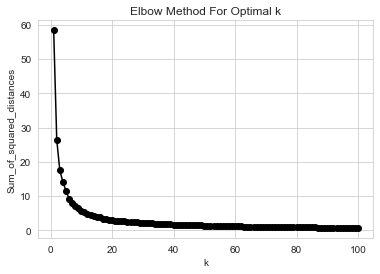

In [182]:
plt.plot(K, inertia, '-o',color = 'black')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [183]:
km = KMeans(n_clusters=5)
km.fit(df_predictions_v2)

KMeans(n_clusters=5)

In [184]:
df_predictions['cluster'] = km.labels_

In [185]:
df_mean_value_by_cluster= df_predictions.groupby('cluster').mean()

In [186]:
df_mean_value_by_cluster

,predprob_Pval0.05,predprob_TargetEnc_Pval0.05,predprob_TargetEnc_Pval0.01,predprob_TargetEnc_Pval0.005
cluster,,,,
0,0.025921,0.025751,0.025921,0.026453
1,0.145237,0.145166,0.171831,0.171054
2,0.080435,0.080205,0.079215,0.079376
3,0.419203,0.420077,0.166172,0.182346
4,0.268337,0.268625,0.361179,0.363855


In [187]:
df_predictions = df_predictions.drop('cluster',1)

In [188]:
from pyod.models.knn import KNN
from sklearn.ensemble import IsolationForest


data = df_predictions
estimation_knn = KNN().fit_predict(data) == 1
outliers_knn = estimation_knn.sum()
print("Количество аномалий (KNN): ", outliers_knn)

estimation_iforest = IsolationForest().fit_predict(data) == -1 
outliers_iforest = estimation_iforest.sum()
print("Количество аномалий (изоляционный лес): ", outliers_iforest)
 
print("Совпало: ", (estimation_knn & estimation_iforest).sum())

Количество аномалий (KNN):  242
Количество аномалий (изоляционный лес):  351
Совпало:  232


In [189]:
df_predictions['knn_outlier'] = estimation_knn
df_predictions['IsolationForest_outlier'] = estimation_iforest
df_predictions['cluster']= km.labels_
df_predictions['outlier']= df_predictions[['knn_outlier', 'IsolationForest_outlier']].all(1)

In [208]:
df_predictions

,predprob_Pval0.05,predprob_TargetEnc_Pval0.05,predprob_TargetEnc_Pval0.01,predprob_TargetEnc_Pval0.005,knn_outlier,IsolationForest_outlier,cluster,outlier
ucdb_id,,,,,,,,
1068809216,0.018064,0.017907,0.017862,0.018920,False,False,0,False
1069323904,0.066127,0.065884,0.020860,0.036078,False,False,0,False
1070123584,0.012844,0.012716,0.024205,0.012077,False,False,0,False
1069249280,0.013508,0.013378,0.029284,0.024807,False,False,0,False
1062806400,0.043957,0.043676,0.073322,0.112204,False,False,2,False
...,...,...,...,...,...,...,...,...
1062391296,0.103110,0.102905,0.189539,0.158421,False,False,1,False
1062331456,0.015058,0.014931,0.019373,0.025616,False,False,0,False
1068496512,0.053920,0.053646,0.032944,0.053591,False,False,0,False
